# Importing and Initiating

In [1]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils

from matplotlib import pyplot as plt

from sklearn.metrics import f1_score

import random

from tqdm import tqdm 

In [2]:
seed=42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate=0.0001
num_epochs=30

train_val_loc = "../input/dyslexia1/Train/"
test_loc = "../input/dyslexia1/Test/"

# DataLoader

In [3]:
# data transformer
data_transform = T.Compose(
    [   
        # to convert to gray scale 
        T.Grayscale(num_output_channels=1),
        T.Resize(size=(28,28)),
        T.ToTensor()
    ]
)

In [4]:
# dataset loading
test_dataset = ImageFolder(test_loc, transform=data_transform)
train_val_dataset = ImageFolder(train_val_loc, transform=data_transform)
print("Data Loaded...")
# Split val and train dataset 
train_size = int(0.85 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_data, val_data = random_split(train_val_dataset, [train_size, val_size])
print("Validation And Train data split")
# dataloder initialization
train_loader = DataLoader(train_data, batch_size = 5000, shuffle = True) 
vald_loader=DataLoader(val_data,batch_size=10000,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=1)
print("Dataloader Initialized")

Data Loaded...
Validation And Train data split
Dataloader Initialized


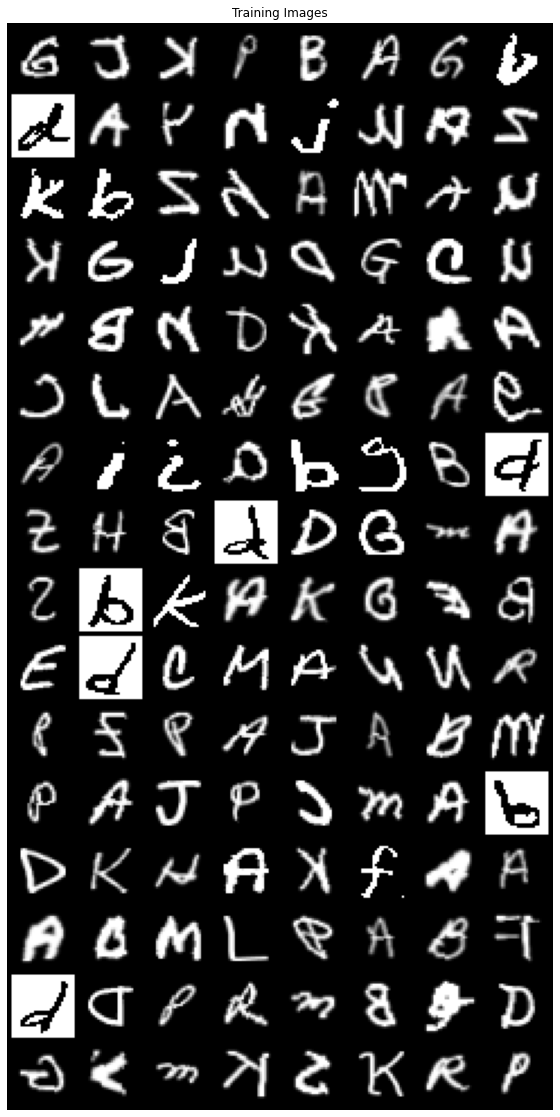

In [5]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(40,20))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:128], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Training

In [6]:
class conv(nn.Module):
    def __init__(self, classes: int):
        super(conv, self).__init__()
        self.convlayer=nn.Sequential(
            #input 1*28*28
            nn.Conv2d(1,32,3,1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,32,3,1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,32,5,2,3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),
            
            nn.Conv2d(32,64,3,1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,3,1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,5,2,3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.1),
        )
        self.linearlayers=nn.Sequential(
            #input 64*6*6
            nn.Flatten(),
            nn.Linear(2304,128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.05),
            nn.Linear(128, classes),
            
            #nn.Softmax(),
        )
        self.softmax=nn.Softmax(dim=1)
    def forward(self,x):
        output=self.convlayer(x)
        output=self.linearlayers(output)
        return self.softmax(output)

In [7]:
def calc_accuracy(true,pred):
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [8]:
model = conv(3).to(device)
train_acc = []
val_acc = []

optimizer = optim.Adam(model.parameters(),0.0005)
total_step = len(train_loader)
model.train()

print("Training Started")

for epoch in range(num_epochs):
    train_run = []
    val_run = []
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output  = model.forward(images)

        labels=labels.long().squeeze()

        loss = F.cross_entropy(output,labels)
        loss.backward()
        optimizer.step()

        train_run.append(calc_accuracy(labels.to("cpu"), output.to("cpu")))
    
    if (epoch+1) % 1 == 0:
        with torch.no_grad():   
            model.eval()
            for i, (images, labels) in enumerate(vald_loader):

                images = images.to(device)
                labels = labels.to(device)


                output  = model.forward(images)

                labels=labels.long().squeeze()

                val_run.append(calc_accuracy(labels.to("cpu"), output.to("cpu")))
        
        
           
        t_acc = (sum(train_run)/len(train_run))
        v_acc = (sum(val_run)/len(val_run))

        print ('Epoch [{}/{}] AC: {:.4f} , Valid_AC:{}'.format(epoch+1, num_epochs, t_acc, v_acc))
        train_acc.append(t_acc)
        val_acc.append(v_acc)

Training Started
Epoch [1/30] AC: 83.4142 , Valid_AC:43.8804
Epoch [2/30] AC: 93.1776 , Valid_AC:64.4396
Epoch [3/30] AC: 95.1798 , Valid_AC:94.57513333333333
Epoch [4/30] AC: 96.8649 , Valid_AC:96.91653333333333
Epoch [5/30] AC: 97.9427 , Valid_AC:98.08783333333334
Epoch [6/30] AC: 98.4829 , Valid_AC:98.59516666666666
Epoch [7/30] AC: 98.7552 , Valid_AC:98.23349999999999
Epoch [8/30] AC: 98.8939 , Valid_AC:98.42146666666667
Epoch [9/30] AC: 99.0706 , Valid_AC:98.95100000000001
Epoch [10/30] AC: 99.2277 , Valid_AC:98.9249
Epoch [11/30] AC: 99.2827 , Valid_AC:99.07916666666667
Epoch [12/30] AC: 99.3825 , Valid_AC:98.9885
Epoch [13/30] AC: 99.4022 , Valid_AC:98.93786666666666
Epoch [14/30] AC: 99.4834 , Valid_AC:98.99516666666666
Epoch [15/30] AC: 99.5318 , Valid_AC:99.09313333333334
Epoch [16/30] AC: 99.5539 , Valid_AC:99.26926666666667
Epoch [17/30] AC: 99.6036 , Valid_AC:98.78786666666667
Epoch [18/30] AC: 99.6232 , Valid_AC:99.14553333333333
Epoch [19/30] AC: 99.6363 , Valid_AC:99.22

# Result

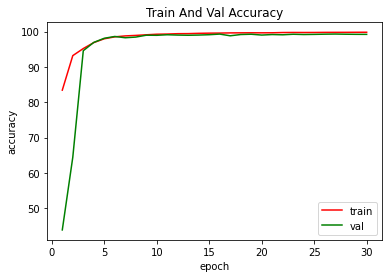

In [9]:
x = [i+1 for i in range(num_epochs)]
plt.plot(x, train_acc, color='r', label='train')
plt.plot(x, val_acc, color='g', label='val')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Train And Val Accuracy")
plt.legend()
plt.show()

In [10]:
result = []
label = []
model.eval()
with torch.no_grad():
    for i in tqdm(test_loader):
        output = model.forward(i[0].to(device))
        result.append(int(output.argmax().to("cpu")))
        label.append(int(i[1]))
print("F1-Score:{}".format(f1_score(result,label,average = "micro")))

100%|██████████| 56723/56723 [07:22<00:00, 128.18it/s]

F1-Score:0.8627364561112775


In [11]:
torch.save(model.state_dict(), "model.pt")